In [2]:
from time import time
import numpy as np
from matplotlib import pyplot as plt

# Qiskit
from qiskit import IBMQ, transpile
from qiskit.providers.ibmq.managed import IBMQJobManager
# Local modules
from utilities import startup, check_provider
from graphstate import GraphState, calc_negativities, calc_entanglement_entropy, plot_negativities_multi, calc_n_mean, plot_cxerr_corr

provider = startup(hub='ibm-q-melbourne', group='unimelb', project='hub')

Account already enabled
Provider: ibm-q-melbourne-unimelb-hub


In [5]:
check_provider()

ibmq_qasm_simulator has 3 queud and simulated qubits
ibmq_montreal has 30 queud and 27 qubits
ibmq_toronto has 2839 queud and 27 qubits
ibmq_kolkata has 0 queud and 27 qubits
ibmq_mumbai has 2 queud and 27 qubits
ibmq_lima has 3 queud and 5 qubits
ibmq_belem has 99 queud and 5 qubits
ibmq_quito has 12 queud and 5 qubits
ibmq_guadalupe has 54 queud and 16 qubits
simulator_statevector has 1 queud and simulated qubits
simulator_mps has 2 queud and simulated qubits
simulator_extended_stabilizer has 2 queud and simulated qubits
simulator_stabilizer has 3 queud and simulated qubits
ibmq_jakarta has 92 queud and 7 qubits
ibmq_manila has 5 queud and 5 qubits
ibm_hanoi has 14 queud and 27 qubits
ibm_lagos has 13 queud and 7 qubits
ibm_nairobi has 14 queud and 7 qubits
ibm_cairo has 0 queud and 27 qubits
ibm_auckland has 12 queud and 27 qubits
ibm_perth has 22 queud and 7 qubits
ibm_washington has 993 queud and 127 qubits
ibm_oslo has 15 queud and 7 qubits
ibm_geneva has 22 queud and 27 qubits
i

In [3]:
import networkx as nx

def plot_fidelities(n_array, backend, nmit_array=None, figsize=(6.4, 4.8)):
    """
    Plot average negativity across multiple experiments with error bars as std

    """

    # Figure
    fig, ax = plt.subplots(figsize=figsize)

    # Extract the mean negativity and its standard deviation
    machine = [f'{backend.name()}']
    
    n_array = np.real(n_array)
    nmit_array = np.real(nmit_array)

    n_mean = np.mean(n_array)
    n_std = np.std(n_array)/np.sqrt(len(n_array))
        
    # Convert into array for plotting
    X = np.array(machine)
    Y0 = np.array(n_mean)
    Y0err = np.array(n_std)
    
    try:
        nmit_mean = np.mean(nmit_array)
        nmit_std = np.std(nmit_array)/np.sqrt(len(nmit_array))

        Y1 = np.array(nmit_mean)
        Y1err = np.array(nmit_std)
        # Order in increasing minimum negativity (QREM)
        #Y1min = Y1 - Y1err
        #idx = Y1min.argsort()#find the indicies that sort Y1min from smallest to largest
        #Y1 = Y1[idx]#then put all negativities in such order (indicies)
        #Y1err = Y1err[idx]
    except:
        # Order in increasing minimum negativity (No QREM)
        Y0min = Y0 - Y0err
        idx = Y0min.argsort()

    
    # Plot
    ax.errorbar(X, Y0, yerr=Y0err, capsize=3, fmt='.', c='r', label=f'No QREM (Mean Fidelity: {np.mean(Y0):.4f})')
    
    try:
        ax.errorbar(X, Y1, yerr=Y1err, capsize=3, fmt='.', c='b', 
                    label=f'QREM (Mean Fidelity: {np.mean(Y1):.4f})')
    except:
        pass
    
    # Fig params
    ax.set_yticks(np.arange(0, 1, 0.05))
    ax.tick_params(axis='x', labelrotation=90)
    ax.grid()
    ax.legend()

    ax.set_xlabel("Machine")
    ax.set_ylabel("fidelities")
    #ax.set_title(f"Native-graph state negativities ({backend.name()})")
    ax.set_title(backend.name)

    return fig

def get_negativity_info(n_list, nmit_list):
    
    n_mean_dict, _ = calc_n_mean(n_list)
    n_mean = np.mean(list(n_mean_dict.values()))
    std = np.std(list(n_mean_dict.values()))/np.sqrt(len(list(n_mean_dict.values())))

    nmit_mean_dict, _ = calc_n_mean(nmit_list)
    nmit_mean = np.mean(list(nmit_mean_dict.values()))
    std_mit = np.std(list(nmit_mean_dict.values()))/np.sqrt(len(list(nmit_mean_dict.values())))
    
    n5 = get_largest_connected(n_mean_dict, threshold=0.025)
    n50 = get_largest_connected(n_mean_dict, threshold=0.25)
    n75 = get_largest_connected(n_mean_dict, threshold=0.75*0.5)
    n90 = get_largest_connected(n_mean_dict, threshold=0.9*0.5)
    
    nmit5 = get_largest_connected(nmit_mean_dict, threshold=0.025)
    nmit50 = get_largest_connected(nmit_mean_dict, threshold=0.25)
    nmit75 = get_largest_connected(nmit_mean_dict, threshold=0.75*0.5)
    nmit90 = get_largest_connected(nmit_mean_dict, threshold=0.9*0.5)
    
    info_dict = {'Mean negativity': n_mean,
                 'std': std,
                'Mean negativity (mit)': nmit_mean,
                 'std (mit)': std_mit,
                'Connected N>5%': len(n5),
                'Connected N>50%': len(n50),
                'Connected N>75%': len(n75),
                'Connected N>90%': len(n90),
                'Connected N>5% (mit)': len(nmit5),
                'Connected N>50% (mit)': len(nmit50),
                'Connected N>75% (mit)': len(nmit75),
                'Connected N>90% (mit)': len(nmit90)}

    return info_dict

def get_single_entanglement_info(n_list, nmit_list):
    
    n_mean_dict, n_std_dict = calc_n_mean(n_list)
    n_mean = np.mean(list(n_mean_dict.values()))
    std = np.mean(list(n_std_dict.values()))

    nmit_mean_dict, nmit_std_dict = calc_n_mean(nmit_list)
    nmit_mean = np.mean(list(nmit_mean_dict.values()))
    std_mit = np.mean(list(nmit_std_dict.values()))
    
    n5 = get_largest_connected(n_mean_dict, threshold=0.025)
    n50 = get_largest_connected(n_mean_dict, threshold=0.25)
    n75 = get_largest_connected(n_mean_dict, threshold=0.75*0.5)
    n90 = get_largest_connected(n_mean_dict, threshold=0.9*0.5)
    
    nmit5 = get_largest_connected(nmit_mean_dict, threshold=0.025)
    nmit50 = get_largest_connected(nmit_mean_dict, threshold=0.25)
    nmit75 = get_largest_connected(nmit_mean_dict, threshold=0.75*0.5)
    nmit90 = get_largest_connected(nmit_mean_dict, threshold=0.9*0.5)
    
    info_dict = {'Mean negativity': n_mean,
                 'std': std,
                'Mean negativity (mit)': nmit_mean,
                 'std (mit)': std_mit,
                'Connected N>5%': len(n5),
                'Connected N>50%': len(n50),
                'Connected N>75%': len(n75),
                'Connected N>90%': len(n90),
                'Connected N>5% (mit)': len(nmit5),
                'Connected N>50% (mit)': len(nmit50),
                'Connected N>75% (mit)': len(nmit75),
                'Connected N>90% (mit)': len(nmit90)}

    return info_dict


def get_largest_connected(n_dict, threshold=0.25):
    
    edges = filter_edges(n_dict, threshold)
    G = nx.Graph()
    G.add_edges_from(edges)
    try:
        largest = max(nx.connected_components(G), key=len)
    except:
        largest = {}
    
    return largest
    
def filter_edges(n_dict, threshold=0.25/2):
    return [key for key, value in n_dict.items() if value >= threshold]



In [2]:
#negativity & entanglement entropy jobs
import csv

#backend = provider.get_backend('ibm_lagos')
backend = provider.get_backend('ibmq_mumbai')
graphstate = GraphState(backend, qubits_to_connect=[0,1,4,7,10,12,15,18,21,23])

#graphstate.batches = {'batch0':[(5,6,3,4)]}
#graphstate.group_list = [(5,6,3,4)]

delays_ns = list(range(0,6000,250))
delays = graphstate.format_delays(delays_ns, unit='ns')
increment = delays[1]-delays[0]

jobs_id = []
jobs_id.append(['jobs','jobs_id'])
#free delay
for t in delays:
    graphstate.gen_delay_circuit(t, increment, dynamic_decoupling=False) #, pulses=4)
    
    job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
    #job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
    jobs_id.append([f'free_delay1-{t}', job1.job_id()])
    #jobs_id.append([f'free_delay2-{t}', job2.job_id()])

#pdd activated
#for t in delays:
#    graphstate.gen_delay_circuit(t, increment, dynamic_decoupling='hahn_echo') #, pulses=4)
    
#    job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
    #job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
#    jobs_id.append([f'pdd1-{t}', job1.job_id()])
    #jobs_id[f'pdd2-{t}'] = job2.job_id()

fp = open('jobs_id_mumbai_free_delay_6000ns','w')
writer = csv.writer(fp, delimiter='|')
writer.writerows(jobs_id)
fp.close()

In [3]:
import csv
jobs_id = {}

fp = open('jobs_id_mumbai_free_delay_6000ns','r')
reader = csv.reader(fp, delimiter='|')
line_count = 0
for row in reader:
    if line_count > 0 and line_count % 2 == 0:
        print(row)
        jobs_id[row[0]] = row[1]
    line_count += 1
fp.close()
print(jobs_id)

['free_delay1-0.0', 'chi6bvr7ca17j32cu7vg']
['free_delay1-1120.0', 'chi6c31ike34bjmjkga0']
['free_delay1-2256.0', 'chi6c61ike34bjmjkk0g']
['free_delay1-3376.0', 'chi6c8k6f7i49rurkdfg']
['free_delay1-4496.0', 'chi6cbb7ca17j32cun1g']
['free_delay1-5632.0', 'chi6ceepqnphtdrm7340']
['free_delay1-6752.0', 'chi6ch46f7i49rurkopg']
['free_delay1-7872.0', 'chi6cjtnopt07g03vmb0']
['free_delay1-9008.0', 'chi6cniae4cj9g8otkkg']
['free_delay1-10128.0', 'chi6cqmpqnphtdrm7jog']
['free_delay1-11248.0', 'chi6ct6pqnphtdrm7n7g']
['free_delay1-12368.0', 'chi6d0k6f7i49rurlbq0']
['free_delay1-13504.0', 'chi6d3b7ca17j32cvj4g']
['free_delay1-14624.0', 'chi6d5qae4cj9g8ou6mg']
['free_delay1-15744.0', 'chi6d937ca17j32cvpo0']
['free_delay1-16880.0', 'chi6dcmpqnphtdrm8ac0']
['free_delay1-18000.0', 'chi6dfb7ca17j32d01a0']
['free_delay1-19120.0', 'chi6dhpike34bjmjmbjg']
['free_delay1-20256.0', 'chi6dl5nopt07g040u2g']
['free_delay1-21376.0', 'chi6dob7ca17j32d0cbg']
['free_delay1-22496.0', 'chi6dqpike34bjmjmmt0']
['fr

In [2]:
# Full QST fidelity jobs
import csv

backend = provider.get_backend('ibm_oslo')
graphstate = GraphState(backend)

delays_ns = list(range(0,15000,1000))
delays = graphstate.format_delays(delays_ns, unit='ns')
increment = delays[1]-delays[0]

jobs_id = []
jobs_id.append(['jobs','jobs_id'])

#free delay
for t in delays:
    graphstate.gen_delay_circuit(t, increment, dynamic_decoupling=False)
    graphstate.gen_full_qst_circuits()
    print(len(graphstate.name_list))
    #job1 = graphstate.run_full_qst_circuits(reps=1, shots=8192, qrem=True, sim=None)

    #jobs_id.append([f'free_delay1-{t}', job1.job_id()])

# hahn echo 
for t in delays:
    graphstate.gen_delay_circuit(t, increment, dynamic_decoupling='double_pulse')
    graphstate.gen_full_qst_circuits()
    
    #job1 = graphstate.run_full_qst_circuits(reps=1, shots=8192, qrem=True, sim=None)

    #jobs_id.append([f'double_pulse-{t}', job1.job_id()])


#pdd activated
for t in delays:
    graphstate.gen_delay_circuit(t, increment, dynamic_decoupling='pdd')
    graphstate.gen_full_qst_circuits()
    
    #job1 = graphstate.run_full_qst_circuits(reps=1, shots=8192, qrem=True, sim=None)

    #jobs_id.append([f'pdd1-{t}', job1.job_id()])


#fp = open('jobs_id_manila_hahn_echo_full_qst_14000ns-1','w')
#writer = csv.writer(fp, delimiter='|')
#writer.writerows(jobs_id)
#fp.close()

2187
2187
2187
2187
2187
2187
2187
2187
2187
2187
2187
2187
2187
2187
2187


In [3]:
import csv
jobs_id = {}

fp = open('jobs_id_manila_hahn_echo_full_qst_21000ns-2','r')
reader = csv.reader(fp, delimiter='|')
line_count = 0
for row in reader:
    if line_count > 0 and line_count % 2 == 0:
        print(row)
        jobs_id[row[0]] = row[1]
    line_count += 1
fp.close()
print(jobs_id)

['free_delay1-0.0', '63dfa49f75f7ef71526d0b24']
['free_delay1-4496.0', '63dfa4b21820a93fbf6ff8b7']
['free_delay1-9008.0', '63dfa4c475f7ef18a26d0b26']
['free_delay1-13504.0', '63dfa4d8690482f4813c0002']
['free_delay1-18000.0', '63dfa4e875f7ef5f4f6d0b28']
['free_delay1-22496.0', '63dfa4f66152641907d2c687']
['free_delay1-27008.0', '63dfa5041820a943e76ff8b9']
['free_delay1-31504.0', '63dfa51133d850a75805b90f']
['free_delay1-36000.0', '63dfa521615264ac52d2c688']
['free_delay1-40496.0', '63dfa53475f7efa12b6d0b2b']
['free_delay1-45008.0', '63dfa547392a66bf0479c430']
['free_delay1-49504.0', '63dfa557a9563a62f83c1ddb']
['free_delay1-54000.0', '63dfa563958cc0b07a9d3b55']
['free_delay1-58496.0', '63dfa56e48082c9e4ecf9569']
['free_delay1-63008.0', '63dfa57975f7ef45a86d0b2e']
['double_pulse-0.0', '63dfa584615264c77dd2c68a']
['double_pulse-4496.0', '63dfa59069048220d53c0004']
['double_pulse-9008.0', '63dfa59e33d8502ce005b912']
['double_pulse-13504.0', '63dfa5b169048201e93c0005']
['double_pulse-18000

0.3314169006523597
0.4880549871878103
0.31665106115701475
0.4796231946992095
0.30593601798723863
0.4678297606907015
0.2936633526617525
0.45473778449607255
0.286664791552242
0.4426912607195306
0.2550429410469918
0.41853012763643727
0.2388012184250188
0.3953414581782979
0.2271269001837916
0.3694218943346306
0.2058745571634974
0.35288690311719145
0.18540089974213544
0.3338809184525754
0.1554804683367735
0.29220971394187906
0.14504548305762627
0.2552706294095144
0.1388954525161803
0.24580184493164556
0.12739371773660918
0.2289728104854906
0.12011711658881875
0.21740306838906717
0.08735867898068223
0.17736451533701592
0.07051795300497815
0.14231305932091945
0.0648290434940742
0.12518859353447498
0.08060177187708169
0.1559897378389706
0.06472033004766065
0.13134635448841453
0.06364885861266274
0.1325380802147326
0.04238942762827024
0.09905139096933027
0.03773043857526169
0.09086387751493774
0.027102114190182214
0.061918376041407375
characteristic life time free delay: 6.065819190437568 us
ch

Text(0, 0.5, 'Negativity')

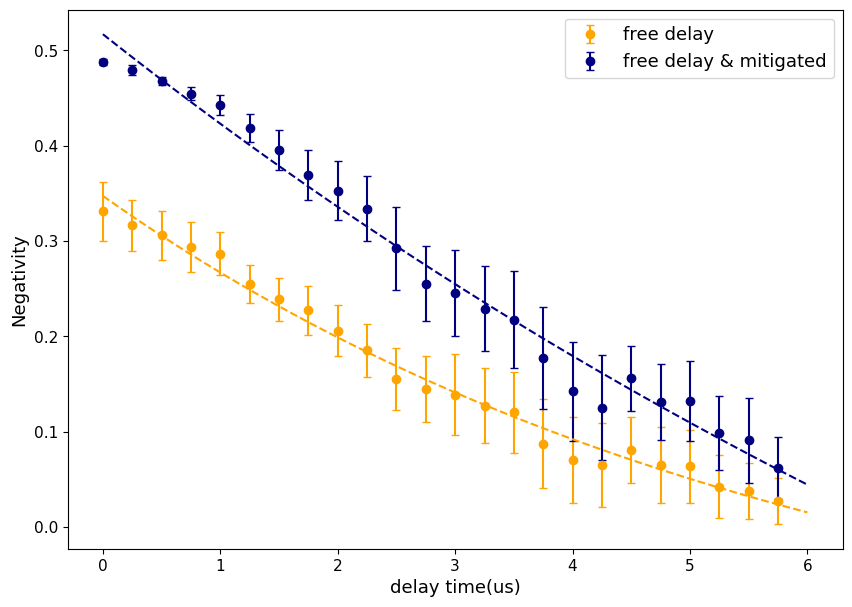

In [16]:
import csv
import scipy.optimize as opt
jobs_id = {}

#fp = open('jobs_id_lagos_hahn_echo_full','r')
fp = open('jobs_id_mumbai_free_delay_6000ns','r')
reader = csv.reader(fp, delimiter='|')
line_count = 0
for row in reader:
    if line_count > 0 and line_count % 2 == 0:
        jobs_id[row[0]] = row[1]
    line_count += 1
fp.close()

backend = provider.get_backend('ibmq_mumbai')
graphstate = GraphState(backend, qubits_to_connect=[0,1,4,7,10,12,15,18,21,23])
#delays_ns = list(range(0,21000,1000))
delays_ns = list(range(0,6000,250))
delays = graphstate.format_delays(delays_ns, unit='ns')
increment = delays[1]-delays[0]

negativities_free_delay = []
negativities_free_delay_std = []

negativities_free_delay_mit = []
negativities_free_delay_mit_std = []

negativities_pdd = []
negativities_pdd_std = []

negativities_pdd_mit = []
negativities_pdd_mit_std = []

#free delay negativities
for t in delays:
    job_id1 = jobs_id[f'free_delay1-{t}']
    #job_id2 = jobs_id[f'free_delay2-{t}']
    job1 = backend.retrieve_job(job_id1)
    #job2 = backend.retrieve_job(job_id2)
    graphstate.gen_delay_circuit(t, increment, dynamic_decoupling = False)
    
    rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
    #rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
    
    n_list1 = calc_negativities(rho_dict1, mode='mean')
    nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
    #n_list2 = calc_negativities(rho_dict2, mode='max')
    #nmit_list2 = calc_negativities(rho_dict_mit2, mode='max')
    n_list = n_list1 #+ n_list2
    nmit_list = nmit_list1 #+ nmit_list2
    
    info = get_negativity_info(n_list, nmit_list)
    print(info['Mean negativity'])
    print(info['Mean negativity (mit)'])
    negativities_free_delay.append(info['Mean negativity'])
    negativities_free_delay_std.append(info['std'])
    
    negativities_free_delay_mit.append(info['Mean negativity (mit)'])
    negativities_free_delay_mit_std.append(info['std (mit)'])

#pdd negativities
#for t in delays:
    #job_id1 = jobs_id[f'pdd1-{t}']
    #job_id2 = jobs_id[f'pdd2-{t}']
    #job1 = backend.retrieve_job(job_id1)
    #job2 = backend.retrieve_job(job_id2)
    #graphstate.gen_delay_circuit(t, increment, dynamic_decoupling = 'hahn_echo')
    
    #rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
    #rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
    
    #n_list1 = calc_negativities(rho_dict1, mode='mean')
    #nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
    #n_list2 = calc_negativities(rho_dict2, mode='max')
    #nmit_list2 = calc_negativities(rho_dict_mit2, mode='max')
    #n_list = n_list1 #+ n_list2
    #nmit_list = nmit_list1 #+ nmit_list2
    
    #info = get_negativity_info(n_list, nmit_list)
    #print(info['Mean negativity'])
    #print(info['Mean negativity (mit)'])
    
    #negativities_pdd.append(info['Mean negativity'])
    #negativities_pdd_std.append(info['std'])
    
    #negativities_pdd_mit.append(info['Mean negativity (mit)'])
    #negativities_pdd_mit_std.append(info['std (mit)'])

t = np.array(delays_ns)/1000

def fit(x, a, b, c):
     return a*np.exp(-b*x)+c

fitted_params_free_delay, _ = opt.curve_fit(fit, t, negativities_free_delay)
fitted_params_free_delay_mit, _ = opt.curve_fit(fit, t, negativities_free_delay_mit)
print(f'characteristic life time free delay: {1/fitted_params_free_delay[1]} us')
print(f'characteristic life time mitigated free delay: {1/fitted_params_free_delay_mit[1]} us')

figsize = (10, 7)
fig, ax = plt.subplots(figsize = figsize)


ax.errorbar(t, negativities_free_delay, yerr=2*np.array(negativities_free_delay_std), capsize=3, ls='none', 
            label = 'free delay', color = 'orange', marker = 'o')

ax.errorbar(t, negativities_free_delay_mit, yerr=2*np.array(negativities_free_delay_mit_std), capsize=3, ls='none',
            label = 'free delay & mitigated', color = 'navy', marker = 'o')
#ax.errorbar(t, negativities_pdd, yerr=negativities_pdd_std, capsize=3, ls='dashed',
#            label = 'hahn echo')

#ax.errorbar(t, negativities_pdd_mit, yerr=negativities_pdd_mit_std, capsize=3, ls= 'dashed',
#            label = 'hahn echo & mitigated')

fit_t = np.linspace(0,6,100)
ax.plot(fit_t, fit(fit_t, *fitted_params_free_delay), color = 'orange', ls = 'dashed')
ax.plot(fit_t, fit(fit_t, *fitted_params_free_delay_mit), color = 'navy', ls = 'dashed')
#ax.vlines(x=0.2, ymin=0, ymax=0.5, color='black', ls='dashed')
#ax.vlines(x=2.2, ymin=0, ymax=0.5, color='black', ls='dashed')
#ax.annotate(f'characteristic life time free delay: {1/fitted_params_free_delay[1]:.2f} us', (1.5,0.15))
#ax.annotate(f'characteristic life time mitigated free delay: {1/fitted_params_free_delay_mit[1]:.2f} us', (4,0.25))
ax.legend(fontsize=13)
ax.tick_params(axis='both', which='major', labelsize=11)
ax.set_xlabel("delay time(us)",fontsize=13)
ax.set_ylabel("Negativity",fontsize=13)
#ax.set_title(backend.name())
####By solving exp(-1/6.0658..*t)=0.17/0.26 (which is the time ratio of dynamic circuits vs post-processing)
####It obtains the time taken for dynamic circuits to execute is 2.577us longer than post-processed circuits
### Which matches the observation on graph (i.e. t=1.3@n=2.5, t= 2.8@n=1.7)
### Compare with mitigated result takes 2us (t=1@n=4.5, t=3@n=2.5)

In [10]:
print(negativities_free_delay_mit_std)

[0.00162352348773453, 0.002441980022478049, 0.0019692134288935305, 0.0032847471728316385, 0.005147608645145997, 0.007225624011566561, 0.010456365675588117, 0.01324487993017444, 0.01558741851984049, 0.016946577884982415, 0.021576678065775196, 0.019614863747887814, 0.022659610483052928, 0.022361198825708233, 0.025483408287759888, 0.026967333728169073, 0.02610618406701949, 0.027425984099064046, 0.016974466127976116, 0.019862848003863696, 0.02101680043412034, 0.019412742347802377, 0.022438261666923892, 0.016410889350945142]


0.20719115283272493
0.20719718819205096
0.19035036250312137
0.18647721815398924
0.1560555619766881
0.14496302990864324
0.144221937643714
0.12912811987581482
0.1350195294188748
0.12406791642084158
0.17559495539023798
0.16872601336159598
0.1908846576626544
0.1892996551593354
0.19291788757842532
0.1913466110650535
0.18925074304250292
0.1856389727350503
0.18290482557145266
0.17883946258826255
0.1867447327685436
0.18427068140266825
0.18774868585737153
0.18412520234741497
0.19427131276955212
0.19100995012731997
0.18958405830030212
0.18616017733945522
0.2001787047767712
0.19896668455148975
0.1959032038955249
0.1923672225192994
0.19310367523203936
0.19003698803547311
0.19373172378439668
0.1914478052806903
0.19777850228348895
0.19481695870938487
0.19122146897258166
0.18858357599152578
0.193324125666852
0.190070161139168
0.19568156179460833
0.19345767757409374
0.19220353677690485
0.18875152268277207
0.15482608599003966
0.14494769806637986
0.1302291071109234
0.11258226232580139
0.1330539631079605

Text(0.5, 1.0, 'ibm_lagos')

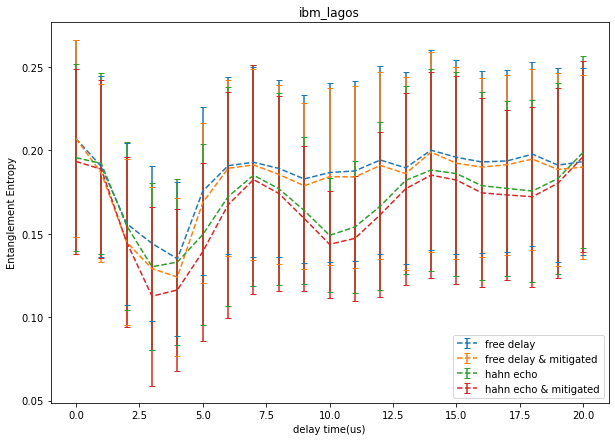

In [4]:
import csv
jobs_id = {}

fp = open('jobs_id_lagos_hahn_echo_full','r')
reader = csv.reader(fp, delimiter='|')
line_count = 0
for row in reader:
    if line_count > 0 and line_count % 2 == 0:
        jobs_id[row[0]] = row[1]
    line_count += 1
fp.close()

backend = provider.get_backend('ibm_lagos')
graphstate = GraphState(backend)


delays_ns = list(range(0,21000,1000))
delays = graphstate.format_delays(delays_ns, unit='ns')
increment = delays[1]-delays[0]
graphstate.gen_delay_circuit(delays[2], increment, dynamic_decoupling = False)

negativities_free_delay = []
negativities_free_delay_std = []

negativities_free_delay_mit = []
negativities_free_delay_mit_std = []

negativities_pdd = []
negativities_pdd_std = []

negativities_pdd_mit = []
negativities_pdd_mit_std = []

#free delay negativities
for t in delays:
    job_id1 = jobs_id[f'free_delay1-{t}']
    #job_id2 = jobs_id[f'free_delay2-{t}']
    job1 = backend.retrieve_job(job_id1)
    #job2 = backend.retrieve_job(job_id2)
    
    rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
    #rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
    
    n_list1 = calc_entanglement_entropy(rho_dict1)
    nmit_list1 = calc_entanglement_entropy(rho_dict_mit1)
    #n_list2 = calc_negativities(rho_dict2, mode='max')
    #nmit_list2 = calc_negativities(rho_dict_mit2, mode='max')
    n_list = n_list1 #+ n_list2
    nmit_list = nmit_list1 #+ nmit_list2
    
    info = get_negativity_info(n_list, nmit_list)
    print(np.real(info['Mean negativity']))
    print(np.real(info['Mean negativity (mit)']))
    negativities_free_delay.append(np.real(info['Mean negativity']))
    negativities_free_delay_std.append(np.real(info['std']))
    
    negativities_free_delay_mit.append(np.real(info['Mean negativity (mit)']))
    negativities_free_delay_mit_std.append(np.real(info['std (mit)']))

#pdd negativities
for t in delays:
    job_id1 = jobs_id[f'pdd1-{t}']
    #job_id2 = jobs_id[f'pdd2-{t}']
    job1 = backend.retrieve_job(job_id1)
    #job2 = backend.retrieve_job(job_id2)
    
    rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
    #rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
    
    n_list1 = calc_entanglement_entropy(rho_dict1)
    nmit_list1 = calc_entanglement_entropy(rho_dict_mit1)
    #n_list2 = calc_negativities(rho_dict2, mode='max')
    #nmit_list2 = calc_negativities(rho_dict_mit2, mode='max')
    n_list = n_list1 #+ n_list2
    nmit_list = nmit_list1 #+ nmit_list2
    
    info = get_negativity_info(n_list, nmit_list)
    print(np.real(info['Mean negativity']))
    print(np.real(info['Mean negativity (mit)']))
    
    negativities_pdd.append(np.real(info['Mean negativity']))
    negativities_pdd_std.append(np.real(info['std']))
    
    negativities_pdd_mit.append(np.real(info['Mean negativity (mit)']))
    negativities_pdd_mit_std.append(np.real(info['std (mit)']))

t = np.array(delays_ns)/1000


figsize = (10, 7)
fig, ax = plt.subplots(figsize = figsize)
ax.errorbar(t, negativities_free_delay, yerr=negativities_free_delay_std, capsize=3, ls='dashed', 
            label = 'free delay')

ax.errorbar(t, negativities_free_delay_mit, yerr=negativities_free_delay_mit_std, capsize=3, ls='dashed',
            label = 'free delay & mitigated')

ax.errorbar(t, negativities_pdd, yerr=negativities_pdd_std, capsize=3, ls='dashed',
            label = 'hahn echo')

ax.errorbar(t, negativities_pdd_mit, yerr=negativities_pdd_mit_std, capsize=3, ls= 'dashed',
            label = 'hahn echo & mitigated')
ax.legend()
ax.set_xlabel("delay time(us)")
ax.set_ylabel("Entanglement Entropy")
ax.set_title(backend.name())


0.3951833379347284
0.49667858095614337
0.3515184888868783
0.42295144217454794
0.1863838453430311
0.22993169586285056
0.004480794582051898
0.02498955813298415
0.0
0.0
0.002106231773975771
0.012405602644687212
0.0
0.003098611247371247
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.004209392051255899
0.02225185809102394
0.0
0.0
0.3500390458461222
0.4216645673523858
0.20214647377781444
0.24486443466247804
0.045340348390531554
0.06661830479672703
0.034748733159600025
0.05436525905536594
0.18838811649083986
0.22940834590188283
0.28729969954296625
0.3497262009913893
0.29276059306350827
0.37979593784491184
0.24707496627248432
0.32873654339736735
0.1635160474261308
0.22134713289041855
0.028798235038127944
0.05466779326550967
0.0
0.0
0.07666999423832069
0.11242989773303598
0.16558409966051665
0.21387194560738176
0.21301113637448313
0.2657311415908193


Text(0.5, 1.0, 'ibm_lagos')

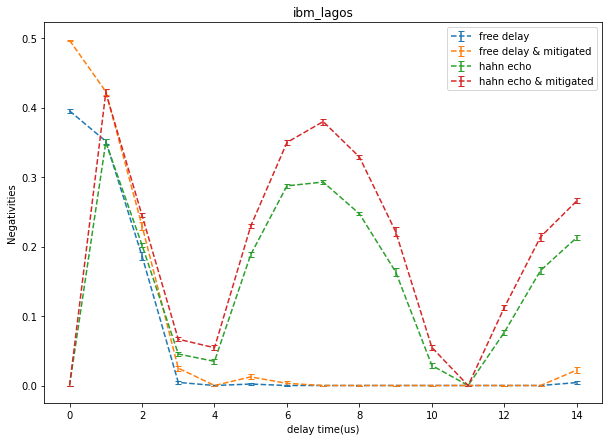

In [4]:
import csv
jobs_id = {}

fp = open('jobs_id_lagos_hahn_echo_(5,6)_15000ns','r')
reader = csv.reader(fp, delimiter='|')
line_count = 0
for row in reader:
    if line_count > 0 and line_count % 2 == 0:
        jobs_id[row[0]] = row[1]
    line_count += 1
fp.close()

backend = provider.get_backend('ibm_lagos')
graphstate = GraphState(backend)

graphstate.batches = {'batch0':[(5,6,3,4)]}
graphstate.group_list = [(5,6,3,4)]

delays_ns = list(range(0,15000,1000))
delays = graphstate.format_delays(delays_ns, unit='ns')
increment = delays[1]-delays[0]


negativities_free_delay = []
negativities_free_delay_std = []

negativities_free_delay_mit = []
negativities_free_delay_mit_std = []

negativities_pdd = []
negativities_pdd_std = []

negativities_pdd_mit = []
negativities_pdd_mit_std = []

#free delay negativities
for t in delays:
    job_id1 = jobs_id[f'free_delay1-{t}']
    #job_id2 = jobs_id[f'free_delay2-{t}']
    job1 = backend.retrieve_job(job_id1)
    #job2 = backend.retrieve_job(job_id2)
    graphstate.gen_delay_circuit(t, increment, dynamic_decoupling=False)
    
    rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
    #rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
    rho_dict1_new = [{(5,6): rep[(5,6)]} for rep in rho_dict1]
    rho_dict_mit1_new = [{(5,6): rep[(5,6)]} for rep in rho_dict_mit1]

    n_list1 = calc_negativities(rho_dict1_new, mode = 'mean')
    nmit_list1 = calc_negativities(rho_dict_mit1_new, mode = 'mean')

    #n_list1 = calc_negativities(rho_dict1, mode='mean')
    #nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
    #n_list2 = calc_negativities(rho_dict2, mode='max')
    #nmit_list2 = calc_negativities(rho_dict_mit2, mode='max')
    n_list = n_list1 #+ n_list2
    nmit_list = nmit_list1 #+ nmit_list2

    info = get_single_entanglement_info(n_list, nmit_list)
    print(info['Mean negativity'])
    print(info['Mean negativity (mit)'])
    
    negativities_free_delay.append(np.real(info['Mean negativity']))
    negativities_free_delay_std.append(np.real(info['std']))
    
    negativities_free_delay_mit.append(np.real(info['Mean negativity (mit)']))
    negativities_free_delay_mit_std.append(np.real(info['std (mit)']))

#pdd negativities
for t in delays:
    job_id1 = jobs_id[f'pdd1-{t}']
    #job_id2 = jobs_id[f'pdd2-{t}']
    job1 = backend.retrieve_job(job_id1)
    #job2 = backend.retrieve_job(job_id2)
    graphstate.gen_delay_circuit(t, increment, dynamic_decoupling='hahn_echo')
    
    rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
    #rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
    rho_dict1_new = [{(5,6): rep[(5,6)]} for rep in rho_dict1]
    rho_dict_mit1_new = [{(5,6): rep[(5,6)]} for rep in rho_dict_mit1]
    
    n_list1 = calc_negativities(rho_dict1_new, mode = 'mean')
    nmit_list1 = calc_negativities(rho_dict_mit1_new, mode = 'mean')
    
    #n_list1 = calc_negativities(rho_dict1, mode='mean')
    #nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
    #n_list2 = calc_negativities(rho_dict2, mode='max')
    #nmit_list2 = calc_negativities(rho_dict_mit2, mode='max')
    n_list = n_list1 #+ n_list2
    nmit_list = nmit_list1 #+ nmit_list2
    
    info = get_single_entanglement_info(n_list, nmit_list)
    print(info['Mean negativity'])
    print(info['Mean negativity (mit)'])
    
    negativities_pdd.append(np.real(info['Mean negativity']))
    negativities_pdd_std.append(np.real(info['std']))
    negativities_pdd_mit.append(np.real(info['Mean negativity (mit)']))
    negativities_pdd_mit_std.append(np.real(info['std (mit)']))

t = np.array(delays_ns)/1000


figsize = (10, 7)
fig, ax = plt.subplots(figsize = figsize)
ax.errorbar(t, negativities_free_delay, yerr=negativities_free_delay_std, capsize=3, ls='dashed', 
            label = 'free delay')

ax.errorbar(t, negativities_free_delay_mit, yerr=negativities_free_delay_mit_std, capsize=3, ls='dashed',
            label = 'free delay & mitigated')

ax.errorbar(t, negativities_pdd, yerr=negativities_pdd_std, capsize=3, ls='dashed',
            label = 'hahn echo')

ax.errorbar(t, negativities_pdd_mit, yerr=negativities_pdd_mit_std, capsize=3, ls= 'dashed',
            label = 'hahn echo & mitigated')
ax.legend()
ax.set_xlabel("delay time(us)")
ax.set_ylabel("Negativities")
ax.set_title(backend.name())


0.24935455686434324
0.24919950884239567
0.22378185067877432
0.21750931798961462
0.16893367077686444
0.15210855261826062
0.11254789006442004
0.09047971393070925
0.14474998323609328
0.13019581052954032
0.21276870932342554
0.20674655196499325
0.23775293100122408
0.23529723114642312
0.24792195220680208
0.24769356567288386
0.2459472640574052
0.24520025283260094
0.2432844318182962
0.2416878835596626
0.24327038477734136
0.24208782242176619
0.2481872749028272
0.24808388299046363
0.24822807091738758
0.24800803651266848
0.24390146883524927
0.24319673973435157
0.24693338881460947
0.2468575245010102
0.24245679382208657
0.2417547806286175
0.22687202031845954
0.22118216882259256
0.1769031158907377
0.1650514454083304
0.13299471908108082
0.12178284428801281
0.13729091648756742
0.12542236907708884
0.17473287841764654
0.15938227178479925
0.22817630435835187
0.22081649985232343
0.24951414751468268
0.24907774044456335
0.23870640100375673
0.23650707252349562
0.2067452369058768
0.20041990348460922
0.1744010

Text(0.5, 1.0, 'ibm_lagos')

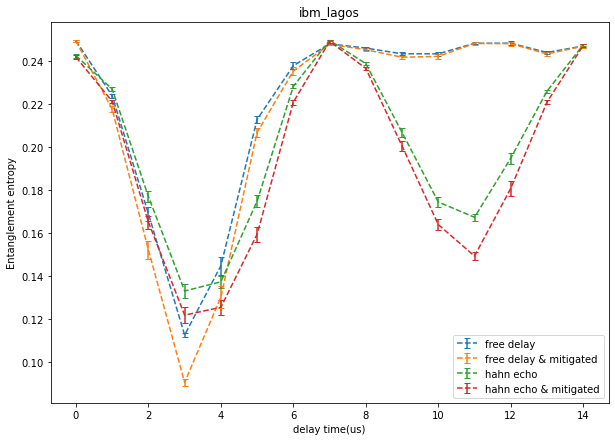

In [5]:
import csv
jobs_id = {}

fp = open('jobs_id_lagos_hahn_echo_(5,6)_15000ns','r')
reader = csv.reader(fp, delimiter='|')
line_count = 0
for row in reader:
    if line_count > 0 and line_count % 2 == 0:
        jobs_id[row[0]] = row[1]
    line_count += 1
fp.close()

backend = provider.get_backend('ibm_lagos')
graphstate = GraphState(backend)

graphstate.batches = {'batch0':[(5,6,3,4)]}
graphstate.group_list = [(5,6,3,4)]

delays_ns = list(range(0,15000,1000))
delays = graphstate.format_delays(delays_ns, unit='ns')
increment = delays[1]-delays[0]

negativities_free_delay = []
negativities_free_delay_std = []

negativities_free_delay_mit = []
negativities_free_delay_mit_std = []

negativities_pdd = []
negativities_pdd_std = []

negativities_pdd_mit = []
negativities_pdd_mit_std = []

#free delay negativities
for t in delays:
    job_id1 = jobs_id[f'free_delay1-{t}']
    #job_id2 = jobs_id[f'free_delay2-{t}']
    job1 = backend.retrieve_job(job_id1)
    #job2 = backend.retrieve_job(job_id2)
    graphstate.gen_delay_circuit(t, increment, dynamic_decoupling=False)
    
    rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')

    rho_dict1_new = [{(5,6): rep[(5,6)]} for rep in rho_dict1]
    rho_dict_mit1_new = [{(5,6): rep[(5,6)]} for rep in rho_dict_mit1]
    #rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
    
    n_list1 = calc_entanglement_entropy(rho_dict1_new)
    nmit_list1 = calc_entanglement_entropy(rho_dict_mit1_new)

    #n_list1 = calc_negativities(rho_dict1, mode='mean')
    #nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
    #n_list2 = calc_negativities(rho_dict2, mode='max')
    #nmit_list2 = calc_negativities(rho_dict_mit2, mode='max')
    n_list = n_list1 #+ n_list2
    nmit_list = nmit_list1 #+ nmit_list2
    
    info = get_single_entanglement_info(n_list, nmit_list)
    print(np.real(info['Mean negativity']))
    print(np.real(info['Mean negativity (mit)']))
    
    negativities_free_delay.append(np.real(info['Mean negativity']))
    negativities_free_delay_std.append(np.real(info['std']))
    
    negativities_free_delay_mit.append(np.real(info['Mean negativity (mit)']))
    negativities_free_delay_mit_std.append(np.real(info['std (mit)']))

#pdd negativities
for t in delays:
    job_id1 = jobs_id[f'pdd1-{t}']
    #job_id2 = jobs_id[f'pdd2-{t}']
    job1 = backend.retrieve_job(job_id1)
    #job2 = backend.retrieve_job(job_id2)
    graphstate.gen_delay_circuit(t, increment, dynamic_decoupling='hahn_echo')
    
    rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
    #rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
    rho_dict1_new = [{(5,6): rep[(5,6)]} for rep in rho_dict1]
    rho_dict_mit1_new = [{(5,6): rep[(5,6)]} for rep in rho_dict_mit1]
    
    n_list1 = calc_entanglement_entropy(rho_dict1_new)
    nmit_list1 = calc_entanglement_entropy(rho_dict_mit1_new)
    
    #n_list1 = calc_negativities(rho_dict1, mode='mean')
    #nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
    #n_list2 = calc_negativities(rho_dict2, mode='max')
    #nmit_list2 = calc_negativities(rho_dict_mit2, mode='max')
    n_list = n_list1 #+ n_list2
    nmit_list = nmit_list1 #+ nmit_list2
    
    info = get_single_entanglement_info(n_list, nmit_list)
    print(np.real(info['Mean negativity']))
    print(np.real(info['Mean negativity (mit)']))
    
    negativities_pdd.append(np.real(info['Mean negativity']))
    negativities_pdd_std.append(np.real(info['std']))
    negativities_pdd_mit.append(np.real(info['Mean negativity (mit)']))
    negativities_pdd_mit_std.append(np.real(info['std (mit)']))

t = np.array(delays_ns)/1000


figsize = (10, 7)
fig, ax = plt.subplots(figsize = figsize)
ax.errorbar(t, negativities_free_delay, yerr=negativities_free_delay_std, capsize=3, ls='dashed', 
            label = 'free delay')

ax.errorbar(t, negativities_free_delay_mit, yerr=negativities_free_delay_mit_std, capsize=3, ls='dashed',
            label = 'free delay & mitigated')

ax.errorbar(t, negativities_pdd, yerr=negativities_pdd_std, capsize=3, ls='dashed',
            label = 'hahn echo')

ax.errorbar(t, negativities_pdd_mit, yerr=negativities_pdd_mit_std, capsize=3, ls= 'dashed',
            label = 'hahn echo & mitigated')
ax.legend()
ax.set_xlabel("delay time(us)")
ax.set_ylabel("Entanglement entropy")
ax.set_title(backend.name())


In [4]:
import csv
jobs_id = {}

fp = open('jobs_id_manila_hahn_echo_full_qst_21000ns-2','r')
reader = csv.reader(fp, delimiter='|')
line_count = 0
for row in reader:
    if line_count > 0 and line_count % 2 == 0:
        jobs_id[row[0]] = row[1]
    line_count += 1
fp.close()
print(jobs_id)
backend = provider.get_backend('ibmq_manila')
graphstate = GraphState(backend, qubits_to_connect = [0,1,2,3,4])

delays_ns = list(range(0,15000,1000))
delays = graphstate.format_delays(delays_ns, unit='ns')
increment = delays[1]-delays[0]

negativities_free_delay = []
negativities_free_delay_std = []

negativities_free_delay_mit = []
negativities_free_delay_mit_std = []

negativities_double_pulse = []
negativities_double_pulse_std = []

negativities_double_pulse_mit = []
negativities_double_pulse_mit_std = []

negativities_pdd = []
negativities_pdd_std = []

negativities_pdd_mit = []
negativities_pdd_mit_std = []

#free delay fidelities
for t in delays:
    job_id1 = jobs_id[f'free_delay1-{t}']

    job1 = backend.retrieve_job(job_id1)

    graphstate.gen_delay_circuit(t, increment, dynamic_decoupling=False)
    graphstate.gen_full_qst_circuits()
    
    rho_list = graphstate.recon_full_density_mats(job1.result(), apply_mit = False)
    rho_list_mit = graphstate.recon_full_density_mats(job1.result(), apply_mit = 'qrem')
    
    fidelities = graphstate.find_fidelities_to_GraphState(rho_list)
    fidelities_mit = graphstate.find_fidelities_to_GraphState(rho_list_mit)
    
    mean_fidelity = sum(fidelities)/len(fidelities)
    std_fidelity = np.std(fidelities)
    mean_fidelity_mit = sum(fidelities_mit)/len(fidelities_mit)
    std_fidelity_mit = np.std(fidelities_mit)
    
    print(mean_fidelity)
    print(mean_fidelity_mit)
    
    negativities_free_delay.append(np.abs(mean_fidelity))
    negativities_free_delay_std.append(np.abs(std_fidelity))
    
    negativities_free_delay_mit.append(np.abs(mean_fidelity_mit))
    negativities_free_delay_mit_std.append(np.abs(std_fidelity_mit))

    
#double pulse fidelities
for t in delays:
    job_id1 = jobs_id[f'double_pulse-{t}']

    job1 = backend.retrieve_job(job_id1)

    graphstate.gen_delay_circuit(t, increment, dynamic_decoupling='double_pulse')
    graphstate.gen_full_qst_circuits()
    
    rho_list = graphstate.recon_full_density_mats(job1.result(), apply_mit = False)
    rho_list_mit = graphstate.recon_full_density_mats(job1.result(), apply_mit = 'qrem')
    #print(f'trace: {rho_list[0].trace()}')
    #print(f'eigvals:{np.linalg.eig(rho_list[0])[0][1]}')
    #print(f'eigvecs:{np.linalg.eig(rho_list[0])[1][1]}')
    fidelities = graphstate.find_fidelities_to_GraphState(rho_list)
    fidelities_mit = graphstate.find_fidelities_to_GraphState(rho_list_mit)
    
    mean_fidelity = sum(fidelities)/len(fidelities)
    std_fidelity = np.std(fidelities)
    mean_fidelity_mit = sum(fidelities_mit)/len(fidelities_mit)
    std_fidelity_mit = np.std(fidelities_mit)
    
    print(mean_fidelity)
    print(mean_fidelity_mit)
    
    negativities_double_pulse.append(np.abs(mean_fidelity))
    negativities_double_pulse_std.append(np.abs(std_fidelity))
    
    negativities_double_pulse_mit.append(np.abs(mean_fidelity_mit))
    negativities_double_pulse_mit_std.append(np.abs(std_fidelity_mit))
    
    
#pdd fidelities
for t in delays:
    job_id1 = jobs_id[f'pdd1-{t}']

    job1 = backend.retrieve_job(job_id1)

    graphstate.gen_delay_circuit(t, increment, dynamic_decoupling='pdd')
    graphstate.gen_full_qst_circuits()
    
    rho_list = graphstate.recon_full_density_mats(job1.result(), apply_mit = False)
    rho_list_mit = graphstate.recon_full_density_mats(job1.result(), apply_mit = 'qrem')
    
    fidelities = graphstate.find_fidelities_to_GraphState(rho_list)
    fidelities_mit = graphstate.find_fidelities_to_GraphState(rho_list_mit)
    
    mean_fidelity = sum(fidelities)/len(fidelities)
    std_fidelity = np.std(fidelities)
    mean_fidelity_mit = sum(fidelities_mit)/len(fidelities_mit)
    std_fidelity_mit = np.std(fidelities_mit)
    
    print(mean_fidelity)
    print(mean_fidelity_mit)
    
    negativities_pdd.append(np.abs(mean_fidelity))
    negativities_pdd_std.append(np.abs(std_fidelity))
    
    negativities_pdd_mit.append(np.abs(mean_fidelity_mit))
    negativities_pdd_mit_std.append(np.abs(std_fidelity_mit))

{'free_delay1-0.0': '63dfa49f75f7ef71526d0b24', 'free_delay1-4496.0': '63dfa4b21820a93fbf6ff8b7', 'free_delay1-9008.0': '63dfa4c475f7ef18a26d0b26', 'free_delay1-13504.0': '63dfa4d8690482f4813c0002', 'free_delay1-18000.0': '63dfa4e875f7ef5f4f6d0b28', 'free_delay1-22496.0': '63dfa4f66152641907d2c687', 'free_delay1-27008.0': '63dfa5041820a943e76ff8b9', 'free_delay1-31504.0': '63dfa51133d850a75805b90f', 'free_delay1-36000.0': '63dfa521615264ac52d2c688', 'free_delay1-40496.0': '63dfa53475f7efa12b6d0b2b', 'free_delay1-45008.0': '63dfa547392a66bf0479c430', 'free_delay1-49504.0': '63dfa557a9563a62f83c1ddb', 'free_delay1-54000.0': '63dfa563958cc0b07a9d3b55', 'free_delay1-58496.0': '63dfa56e48082c9e4ecf9569', 'free_delay1-63008.0': '63dfa57975f7ef45a86d0b2e', 'double_pulse-0.0': '63dfa584615264c77dd2c68a', 'double_pulse-4496.0': '63dfa59069048220d53c0004', 'double_pulse-9008.0': '63dfa59e33d8502ce005b912', 'double_pulse-13504.0': '63dfa5b169048201e93c0005', 'double_pulse-18000.0': '63dfa5c575f7e

In [4]:
print(negativities_pdd_std)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


characteristic coherence time free delay: 2.1325333576964547 us, standard error: 0.16030790328030478
characteristic coherence time mitigated free delay: 2.010688490136574 us, standard error: 0.13806002375628376
characteristic coherence time double pulse: 4.1958847604828255 us, standard error: 0.3429645777531894
characteristic coherence time mitigated double pulse: 4.196714583109231 us, standard error: 0.36716896642341174
characteristic coherence time PDD: 4.60981217009142 us, standard error: 0.3594845207150744
characteristic coherence time mitigated PDD: 4.571292629037914 us, standard error: 0.36411244741339555


Text(0, 0.5, 'Fidelity')

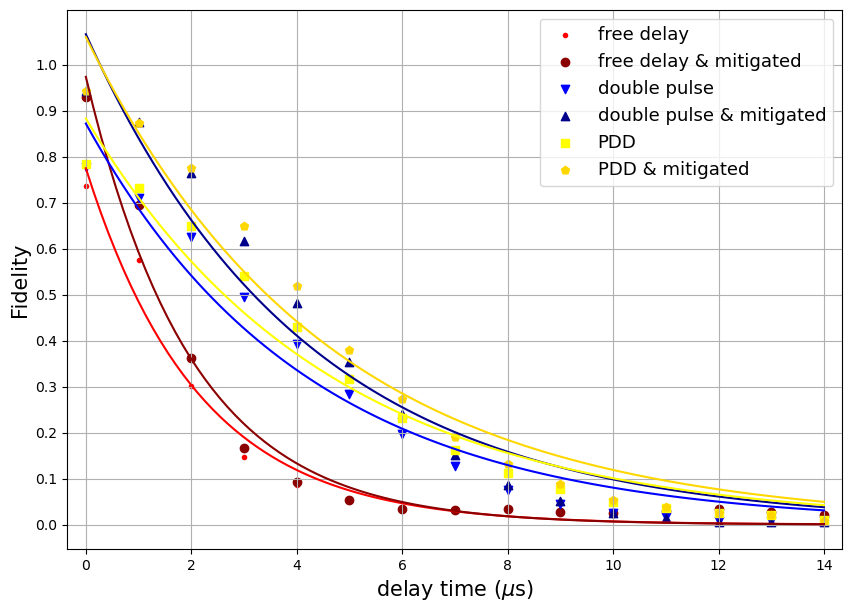

In [11]:
import scipy.optimize as opt

def fit(x, a, b):
     return a*np.exp(-x/b)

 
t = np.array(delays_ns)/1000

fitted_params_free_delay, pcov_free_delay = opt.curve_fit(fit, t, negativities_free_delay)
fitted_params_free_delay_mit, pcov_free_delay_mit = opt.curve_fit(fit, t, negativities_free_delay_mit)
fitted_params_double_pulse, pcov_double_pulse = opt.curve_fit(fit, t, negativities_double_pulse)
fitted_params_double_pulse_mit, pcov_double_pulse_mit = opt.curve_fit(fit, t, negativities_double_pulse_mit)
fitted_params_pdd, pcov_pdd = opt.curve_fit(fit, t, negativities_pdd)
fitted_params_pdd_mit, pcov_pdd_mit = opt.curve_fit(fit, t, negativities_pdd_mit)

print(f'characteristic coherence time free delay: {fitted_params_free_delay[1]} us, standard error: {np.sqrt(pcov_free_delay[1][1])}')
print(f'characteristic coherence time mitigated free delay: {fitted_params_free_delay_mit[1]} us, standard error: {np.sqrt(pcov_free_delay_mit[1][1])}')
print(f'characteristic coherence time double pulse: {fitted_params_double_pulse[1]} us, standard error: {np.sqrt(pcov_double_pulse[1][1])}')
print(f'characteristic coherence time mitigated double pulse: {fitted_params_double_pulse_mit[1]} us, standard error: {np.sqrt(pcov_double_pulse_mit[1][1])}')
print(f'characteristic coherence time PDD: {fitted_params_pdd[1]} us, standard error: {np.sqrt(pcov_pdd[1][1])}')
print(f'characteristic coherence time mitigated PDD: {fitted_params_pdd_mit[1]} us, standard error: {np.sqrt(pcov_pdd_mit[1][1])}')
figsize = (10, 7)
fig, ax = plt.subplots(figsize = figsize)
ax.scatter(t, negativities_free_delay,
           label = 'free delay', color = 'red', marker = '.')

ax.scatter(t, negativities_free_delay_mit,
           label = 'free delay & mitigated', color = 'darkred', marker = 'o')

ax.scatter(t, negativities_double_pulse,
           label = 'double pulse', color = 'blue', marker = 'v')

ax.scatter(t, negativities_double_pulse_mit,
           label = 'double pulse & mitigated', color = 'darkblue', marker = '^')

ax.scatter(t, negativities_pdd,
           label = 'PDD', color = 'yellow', marker = 's')

ax.scatter(t, negativities_pdd_mit,
           label = 'PDD & mitigated', color = 'gold', marker = 'p')
fit_t = np.linspace(0,14,100)
ax.plot(fit_t, fit(fit_t, *fitted_params_free_delay), color = 'red')
ax.plot(fit_t, fit(fit_t, *fitted_params_free_delay_mit), color = 'darkred')
ax.plot(fit_t, fit(fit_t, *fitted_params_double_pulse), color = 'blue')
ax.plot(fit_t, fit(fit_t, *fitted_params_double_pulse_mit), color = 'darkblue')
ax.plot(fit_t, fit(fit_t, *fitted_params_pdd), color = 'yellow')
ax.plot(fit_t, fit(fit_t, *fitted_params_pdd_mit), color = 'gold')
ax.set_yticks(np.arange(0, 1.1, 0.1))
#ax.tick_params(axis='x', labelrotation=90)
ax.grid()
ax.margins(0.025, 0.05)

ax.legend(fontsize=13)
ax.set_xlabel("delay time ($\mu$s)",fontsize=15)
ax.set_ylabel("Fidelity",fontsize=15)

#ax.set_title(backend.name())

In [11]:
import csv
jobs_id = {}

fp = open('jobs_id_manila_hahn_echo_full_qst_21000ns','r')
reader = csv.reader(fp, delimiter='|')
line_count = 0
for row in reader:
    if line_count > 0 and line_count % 2 == 0:
        jobs_id[row[0]] = row[1]
    line_count += 1
fp.close()

backend = provider.get_backend('ibmq_manila')
graphstate = GraphState(backend)


delays_ns = list(range(0,21000,1000))
delays = graphstate.format_delays(delays_ns, unit='ns')
increment = delays[1]-delays[0]

graphstate.gen_delay_circuit(delays[2], increment, dynamic_decoupling='double_pulse')
#graphstate.qst_circuits['batch1']['XX'].draw()
graphstate.gen_full_qst_circuits()

job_id1 = jobs_id['pdd1-9008.0']
job1 = backend.retrieve_job(job_id1)
full_qst_pvecs_multi, _ = graphstate.full_qst_pvecs_from_result(job1.result())
print(graphstate.reps)
print(full_qst_counts_multi[0])
print(job1.result().get_counts('XXXXX-0'))
#rho_list_mit = graphstate.recon_full_density_mats(job1.result(), apply_mit = 'M3')

1
{'XXXXX': {'00000': 371, '00001': 81, '10000': 60, '10001': 334, '10010': 129, '10011': 343, '10100': 364, '10101': 64, '10110': 408, '10111': 106, '11000': 90, '11001': 309, '11010': 169, '11011': 363, '11100': 372, '11101': 105, '11110': 508, '11111': 221, '00010': 436, '00011': 143, '00100': 75, '00101': 362, '00110': 156, '00111': 361, '01000': 395, '01001': 111, '01010': 420, '01011': 123, '01100': 118, '01101': 403, '01110': 236, '01111': 456}, 'XXXXY': {'00000': 182, '00001': 193, '10000': 255, '10001': 228, '10010': 347, '10011': 353, '10100': 186, '10101': 208, '10110': 218, '10111': 152, '11000': 350, '11001': 294, '11010': 362, '11011': 229, '11100': 427, '11101': 414, '11110': 524, '11111': 593, '00010': 209, '00011': 166, '00100': 244, '00101': 211, '00110': 351, '00111': 340, '01000': 129, '01001': 139, '01010': 187, '01011': 222, '01100': 111, '01101': 125, '01110': 140, '01111': 103}, 'XXXXZ': {'00000': 215, '00001': 163, '10000': 214, '10001': 214, '10010': 297, '100

In [4]:
# Full QST fidelity jobs
backend = provider.get_backend('ibmq_mumbai')
graphstate = GraphState(backend, qubits_to_connect = [3,5,8,11,14,16])

graphstate.gen_full_qst_circuits()
print(len(graphstate.name_list))

#job = graphstate.run_full_qst_circuits(reps=1, shots=4096, qrem=True, sim='device')
#result = job.result()
#rho_list = graphstate.recon_full_density_mats(result, apply_mit = False)
#rho_list_mit = graphstate.recon_full_density_mats(result, apply_mit = 'qrem')

#fidelities = graphstate.find_fidelities_to_GraphState(rho_list)
#fidelities_mit = graphstate.find_fidelities_to_GraphState(rho_list_mit)
#print(np.mean(fidelities))
#print(np.mean(fidelities_mit))
circ_list = []
for circuit in graphstate.full_qst_circuits.values():
    circ_list.append(circuit)

circ_list_multi = []
for i in range(8):
    for circ in circ_list:
        name_ext = circ.name + f'-{i}'
        circ_list_multi.append(circ.copy(name_ext))
circ_list = circ_list_multi 

qrem_circuits = graphstate.gen_qrem_circuits()
circ_list.extend(qrem_circuits)
print(len(circ_list))

circ_list = transpile(circ_list, backend=graphstate.backend)
job_manager = IBMQJobManager()
job_set = job_manager.run(circ_list, backend=graphstate.backend, max_experiments_per_job=4096)
print(job_set.job_set_id())

729
5834
6f8e40e053e642ada7e0a230a36d03d1-1680310590952986


In [8]:
from qiskit.circuit.random import random_circuit

backend = provider.get_backend('ibmq_qasm_simulator')

circ_list = []
for i in range(600):
    circ = random_circuit(2,2, measure=True)
    circ_list.append(circ)
circ_list = transpile(circ_list, backend=backend)
job_manager = IBMQJobManager()
job_set = job_manager.run(circ_list, backend=backend, max_experiments_per_job=100)
print(job_set.job_set_id())

d89c9b3b4c1f457f88781ecacae6cad1-16789456187525244


In [14]:
backend = provider.get_backend('ibmq_qasm_simulator')
job_manager = IBMQJobManager()
job_set = job_manager.retrieve_job_set('d89c9b3b4c1f457f88781ecacae6cad1-16789456187525244', provider)
results = job_set.results()
result = results.combine_results()
print(len(result.results))

600


5-qubit Graph State full QST on 7 qubit machine

In [2]:
backend = provider.get_backend('ibm_perth')
graphstate = GraphState(backend, qubits_to_connect = [0,1,2,3,5])
graphstate.gen_full_qst_circuits()

job_manager = IBMQJobManager()
job_set = job_manager.retrieve_job_set('ab5d639b6a7b4156803a019ca34aecbf-16792916520935655', provider)
results = job_set.results()
result = results.combine_results()
print(result.results)
#pvecs, counts = graphstate.full_qst_pvecs_from_result(result)
#pvecs = graphstate.apply_qrem_entanglement_witness_intactness(pvecs)
#print(pvecs)
rho_list = graphstate.recon_full_density_mats(result, apply_mit = False)
rho_list_mit = graphstate.recon_full_density_mats(result, apply_mit = 'qrem')

fidelities = graphstate.find_fidelities_to_GraphState(rho_list)
fidelities_mit = graphstate.find_fidelities_to_GraphState(rho_list_mit)

[ExperimentResult(shots=4000, success=True, meas_level=2, data=ExperimentResultData(counts={'0x0': 152, '0x1': 36, '0x10': 162, '0x11': 31, '0x12': 192, '0x13': 37, '0x14': 35, '0x15': 262, '0x16': 56, '0x17': 242, '0x18': 209, '0x19': 36, '0x1a': 225, '0x1b': 41, '0x1c': 51, '0x1d': 191, '0x1e': 48, '0x1f': 228, '0x2': 150, '0x3': 30, '0x4': 45, '0x5': 264, '0x6': 39, '0x7': 214, '0x8': 185, '0x9': 38, '0xa': 225, '0xb': 46, '0xc': 51, '0xd': 229, '0xe': 48, '0xf': 202}), header=QobjExperimentHeader(qubit_labels=[['q', 0], ['q', 1], ['q', 2], ['q', 3], ['q', 4], ['q', 5], ['q', 6]], n_qubits=7, qreg_sizes=[['q', 7]], clbit_labels=[['c0', 0], ['c0', 1], ['c0', 2], ['c0', 3], ['c0', 4]], memory_slots=5, creg_sizes=[['c0', 5]], name='XXXXX-0', global_phase=4.71238898038469, metadata={}), status=done), ExperimentResult(shots=4000, success=True, meas_level=2, data=ExperimentResultData(counts={'0x0': 209, '0x1': 35, '0x10': 131, '0x11': 33, '0x12': 144, '0x13': 30, '0x14': 77, '0x15': 326, 

In [3]:
print(np.mean(fidelities))
print(np.mean(fidelities_mit))

(0.8511167436628715+8.673617379884035e-19j)
(0.9555854606926062+0j)


In [22]:
from qiskit import QuantumCircuit
from qiskit.visualization import circuit_drawer
a = QuantumCircuit(4)
b = a.copy('U')
a.append(b.to_instruction(),[0,1,2,3])
a.delay(1)
a.x([0,1,2,3])
a.delay(2)
a.x([0,1,2,3])
a.delay(2)
a.x([0,1,2,3])
a.delay(1)
a.measure_all()
a.draw()
print(circuit_drawer(a, output='latex_source'))

\documentclass[border=2px]{standalone}

\usepackage[braket, qm]{qcircuit}
\usepackage{graphicx}

\begin{document}
\scalebox{1.0}{
\Qcircuit @C=1.0em @R=0.2em @!R { \\
	 	\nghost{{q}_{0} :  } & \lstick{{q}_{0} :  } & \multigate{3}{\mathrm{U}}_<<<{0} & \gate{\mathrm{Delay}\,(\mathrm{1[dt]})} & \gate{\mathrm{X}} & \gate{\mathrm{Delay}\,(\mathrm{2[dt]})} & \gate{\mathrm{X}} & \gate{\mathrm{Delay}\,(\mathrm{2[dt]})} & \gate{\mathrm{X}} & \gate{\mathrm{Delay}\,(\mathrm{1[dt]})} \barrier[0em]{3} & \qw & \meter & \qw & \qw & \qw & \qw & \qw\\
	 	\nghost{{q}_{1} :  } & \lstick{{q}_{1} :  } & \ghost{\mathrm{U}}_<<<{1} & \gate{\mathrm{Delay}\,(\mathrm{1[dt]})} & \gate{\mathrm{X}} & \gate{\mathrm{Delay}\,(\mathrm{2[dt]})} & \gate{\mathrm{X}} & \gate{\mathrm{Delay}\,(\mathrm{2[dt]})} & \gate{\mathrm{X}} & \gate{\mathrm{Delay}\,(\mathrm{1[dt]})} & \qw & \qw & \meter & \qw & \qw & \qw & \qw\\
	 	\nghost{{q}_{2} :  } & \lstick{{q}_{2} :  } & \ghost{\mathrm{U}}_<<<{2} & \gate{\mathrm{Delay}\,(\mathrm{1

6-qubit Graph State full QST on 7 qubit machine

In [6]:
backend = provider.get_backend('ibmq_jakarta')
#graphstate = GraphState(backend, qubits_to_connect = [3,5,8,11,14,16])
graphstate = GraphState(backend, qubits_to_connect = [0,1,2,3,4,5])
graphstate.gen_full_qst_circuits()

job_manager = IBMQJobManager()
#job_set = job_manager.retrieve_job_set('6f8e40e053e642ada7e0a230a36d03d1-1680310590952986', provider)
job_set = job_manager.retrieve_job_set('2678834701ed4827a797df4be6c5cf51-1680227877017411', provider)
results = job_set.results()
result = results.combine_results()
print('result get')
#pvecs, counts = graphstate.full_qst_pvecs_from_result(result)
#pvecs = graphstate.apply_qrem_entanglement_witness_intactness(pvecs)
#print(pvecs)
rho_list = graphstate.recon_full_density_mats(result, apply_mit = False)
print('rho_list get')
rho_list_mit = graphstate.recon_full_density_mats(result, apply_mit = 'qrem')

fidelities = graphstate.find_fidelities_to_GraphState(rho_list)
fidelities_mit = graphstate.find_fidelities_to_GraphState(rho_list_mit)

result get
rho_list get


In [7]:
print(rho_list_mit[0])

[[ 0.01391769-1.10038997e-18j  0.01131088-5.25348037e-04j
   0.01301069-4.70580253e-04j ...  0.01251314-4.40455228e-03j
  -0.01151252+3.56201943e-03j -0.01367507+4.89786394e-03j]
 [ 0.01131088+5.25348037e-04j  0.01494717-1.73109215e-18j
   0.01382079-1.00949130e-03j ...  0.01278142-1.83986163e-03j
  -0.00927816+2.26437371e-03j -0.01443793+4.97217758e-03j]
 [ 0.01301069+4.70580253e-04j  0.01382079+1.00949130e-03j
   0.01634736-1.44852984e-18j ...  0.01369562-2.31566893e-03j
  -0.01084815+2.93235418e-03j -0.01635632+4.99164080e-03j]
 ...
 [ 0.01251314+4.40455228e-03j  0.01278142+1.83986163e-03j
   0.01369562+2.31566893e-03j ...  0.01583683-1.13084938e-18j
  -0.01232944-6.89043259e-04j -0.01584745+1.48703515e-03j]
 [-0.01151252-3.56201943e-03j -0.00927816-2.26437371e-03j
  -0.01084815-2.93235418e-03j ... -0.01232944+6.89043259e-04j
   0.01233073-1.10948182e-18j  0.01231342-1.12249952e-04j]
 [-0.01367507-4.89786394e-03j -0.01443793-4.97217758e-03j
  -0.01635632-4.99164080e-03j ... -0.01584

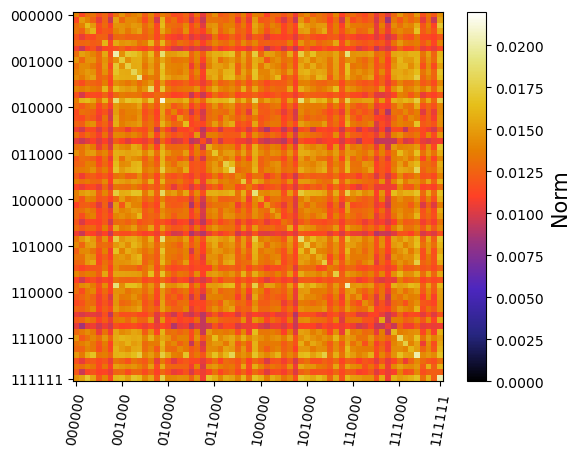

In [13]:
import matplotlib as mpl

cmap = mpl.colormaps['hsv']
#plt.imshow(np.angle(rho_list_mit[0]), cmap=cmap)
plt.imshow(np.abs(rho_list_mit[0]), cmap=plt.cm.CMRmap)
#cmap=plt.cm.CMRmap
#norm = mpl.colors.Normalize(vmin=0, vmax=0.1)
#im = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
label_list = ['000000', '001000', '010000', '011000', '100000', '101000','110000','111000','111111']
phase_ticks = ['-π', '-2π/3','-π/3','0','π/3','2π/3','π']
plt.xticks([0,8,16,24,32,40,48,56,63], label_list)
plt.yticks([0,8,16,24,32,40,48,56,63], label_list)
plt.tick_params(axis='x', labelrotation=80)
plt.clim(0, 0.022)
#plt.clim(-np.pi, np.pi)
cb = plt.colorbar(orientation='vertical', label='Norm')
#cb = plt.colorbar(orientation='vertical', label='Phase', ticks=[-np.pi, -2*np.pi/3, -np.pi/3, 0, np.pi/3, 2*np.pi/3, np.pi])
#cb.ax.set_yticklabels(phase_ticks)
cb.set_label(label = 'Norm', size=15)
plt.show()

(0.8093497791480295+4.119968255444917e-18j)
0.02293027784553207
(0.9255016297326459+8.673617379884035e-19j)
0.013592811540061494


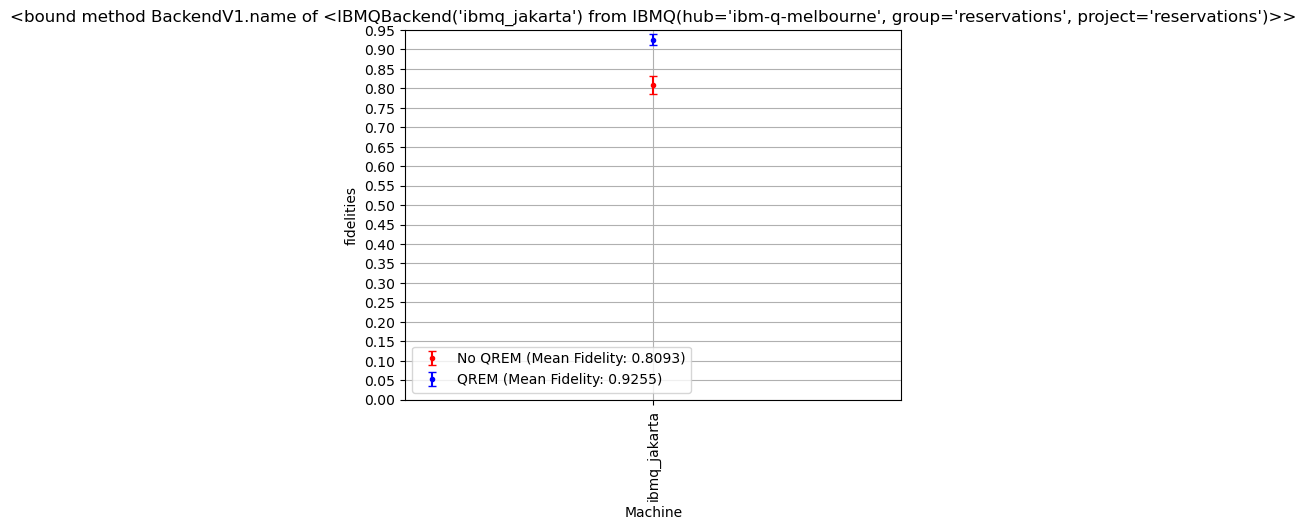

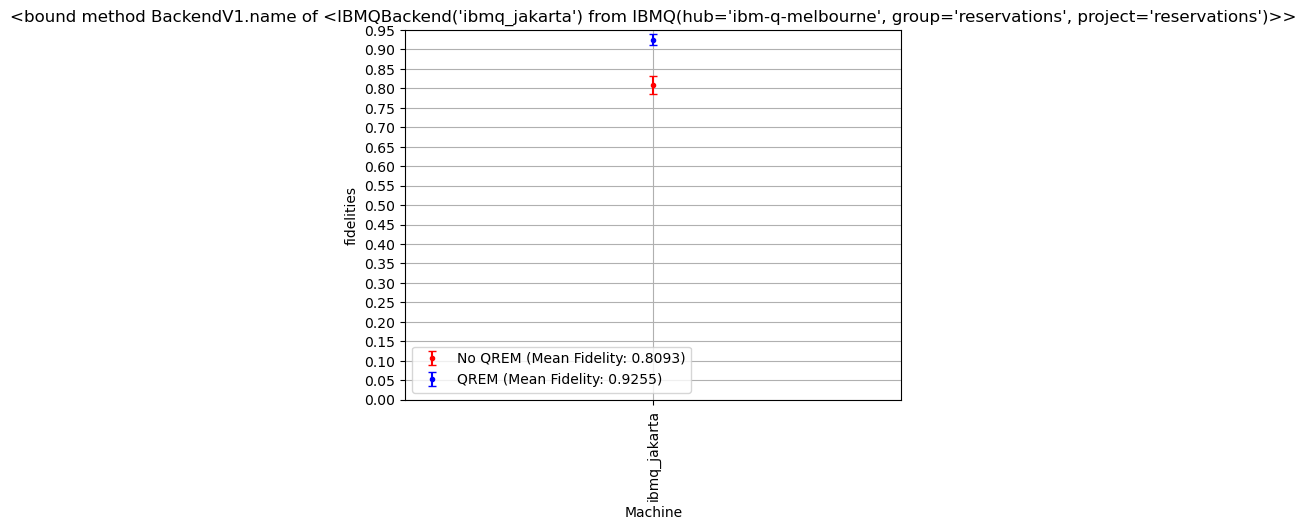

In [7]:
print(np.mean(fidelities))
print(np.std(fidelities)/np.sqrt(len(fidelities)))
print(np.mean(fidelities_mit))
print(np.std(fidelities_mit)/np.sqrt(len(fidelities_mit)))
plot_fidelities(fidelities, backend, nmit_array=fidelities_mit, figsize=(6.4, 4.8))